<a href="https://colab.research.google.com/github/Aspire-Mayank/Zero2GAN-Pytorch/blob/master/CourseProject/ZeroToGANs_CourseProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Pytorch Zero2GAN Course Project***
## Facial Emotion Recognition for a Recommendation System
* Objective: Face Emotion Recognition project aims at predicting the emotions of the user based on their facial image.

* Motivation: The motivation for this project came from the recommendation systems. Often we see products recommended based on the user's search history, watch history , purchase history etc. These sort of systems depend on the past history and records. We with this project want to use real-time recommendation system. The system will use our model to predict the emotion of the user based on his facial expressions and will recommend products to suit the mood of the user.

***Special thanks to course Instructor Aakash From JovianML Community***


#### [Reference: FB Hacakthone 2020 challege](https://fbai1.devpost.com/?ref_feature=challenge&ref_medium=home)

In [1]:
# Mounting your google drive in order to download & load the dataset and save the trained model.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pwd

/content


###### Kaggle Configuration for running in colab

In [1]:
# Upload your Kaggle API in order to download the required dataset.
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

#### Installs a version of the Kaggle API package

In [5]:
# installing kaggle package.

!pip install kaggle==1.5.6

In [6]:
# Preparing the API for downloading
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [7]:
# Download 'face-expression-recognition-dataset' datset from Kaggle datsets in 'Colab Notebooks' directory.
!kaggle datasets download jonathanoheix/face-expression-recognition-dataset -p /content/gdrive/My\ Drive/Colab\ Notebooks

 99% 119M/121M [00:03<00:00, 35.0MB/s]
100% 121M/121M [00:03<00:00, 36.4MB/s]


In [8]:
# Unzipping the downloaded file from Kaggle which contains the data.
img = !unzip /content/gdrive/My\ Drive/Colab\ Notebooks/face-expression-recognition-dataset.zip

## Preparing the dataset for training and validation

In [9]:
import shutil
shutil.rmtree('/content/images/images')

In [10]:
!mv /content/images/validation /content/images/valid

In [11]:
import numpy as np
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
idx = [str(i) for i in np.arange(7)]
cat_to_name = dict(zip(idx, classes))
cat_to_name

{'0': 'angry',
 '1': 'disgust',
 '2': 'fear',
 '3': 'happy',
 '4': 'neutral',
 '5': 'sad',
 '6': 'surprise'}

In [12]:
import shutil
train_path = '/content/images/train'
valid_path = '/content/images/valid'
for i in range(len(cat_to_name)):
    shutil.move(train_path + '/' + cat_to_name[str(i)], train_path + '/' + str(i))
    shutil.move(valid_path + '/' + cat_to_name[str(i)], valid_path + '/' + str(i))

In [13]:
 #Package imports.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split

import json
from time import time
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# Directories.

data_dir = 'images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'


In the cell below, we call transforms.Normalize to Normalize a tensor image with mean and standard deviation.

The Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

Parameters selected:

mean (sequence) – Sequence of means for each channel.

std (sequence) – Sequence of standard deviations for each channel.

This was used for both the train and valid data transforms

In [15]:
# Data augmentation and Normalization.
stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
# Defining transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(), 
                                                transforms.Normalize(*stats)
                                                ]),
                   'valid': transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(*stats)
                                                ])}

# Loading the datasets with ImageFolder.
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
                 }

# Using the image datasets and the transforms to define the dataloaders.
dataloaders = {'trainloader': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
               'validloader': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64)
              }

## Creating a set for testing because the dowmladed dataset has only training and validation sets.

In [16]:
valid_size = int(0.8 * len(image_datasets['valid']))
test_size = len(image_datasets['valid']) - valid_size
_, test_data = torch.utils.data.random_split(image_datasets['valid'], [valid_size, test_size])
image_datasets['test'] = test_data
dataloaders['testloader'] =  torch.utils.data.DataLoader(image_datasets['test'], batch_size=64)

## Displaying samples from training set

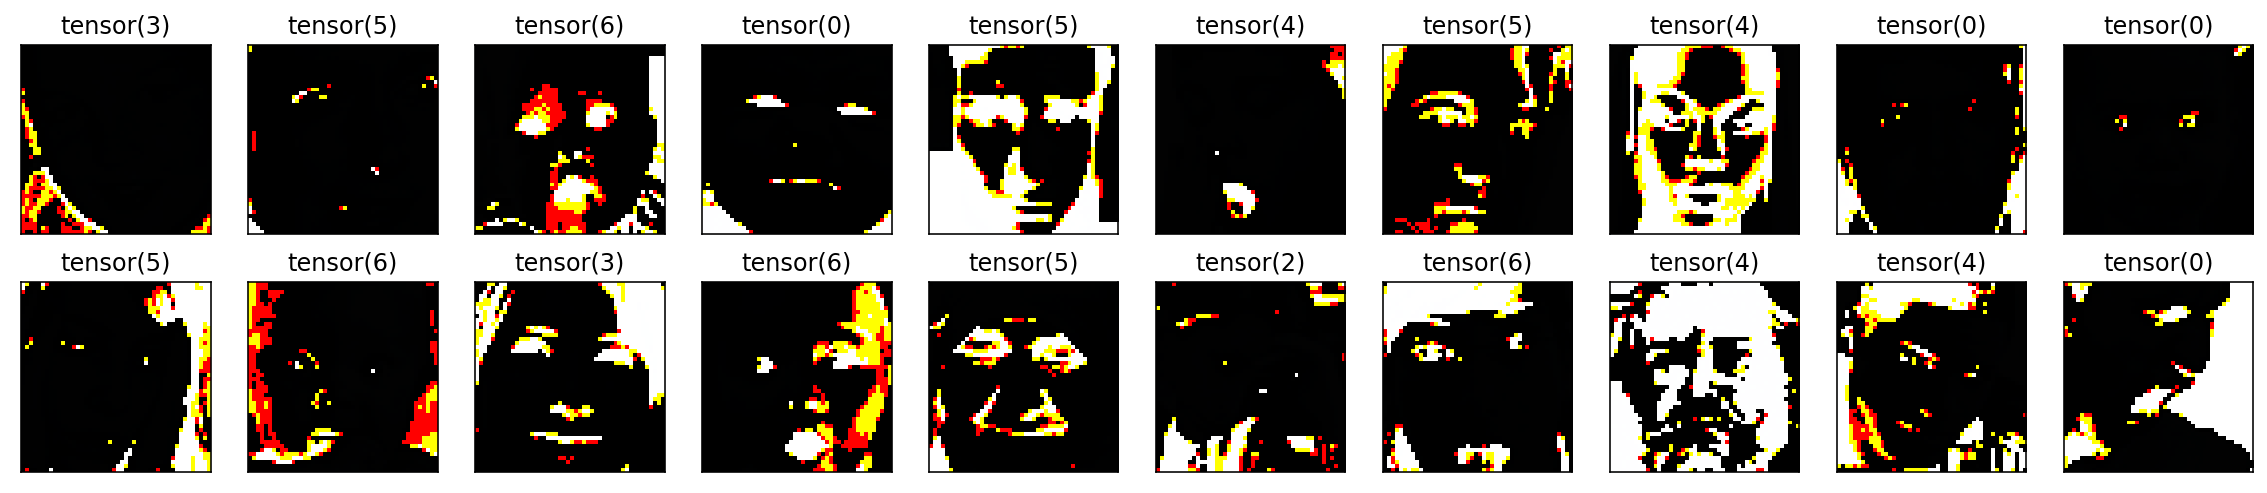

In [17]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).astype(np.uint8))

image,label=iter(dataloaders['trainloader']).next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(image[idx])
    ax.set_title(label[idx])


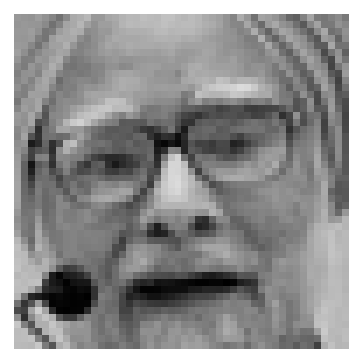

In [18]:
import cv2

# load color (BGR) image
img = cv2.imread("/content/images/train/0/1.jpg")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.figure(figsize=(3,6))
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

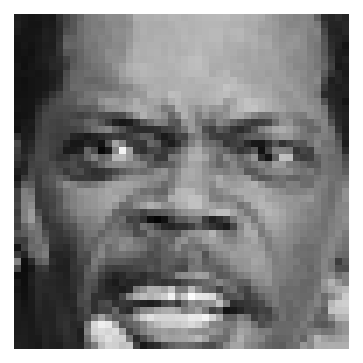

In [19]:
import cv2

# load color (BGR) image
img = cv2.imread("/content/images/train/0/10.jpg")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.figure(figsize=(3,6))
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

## Displaying samples from training set

In [20]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline

In [21]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [23]:
def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=10).permute(1, 2, 0))

def show_batch(dl, nmax=128):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


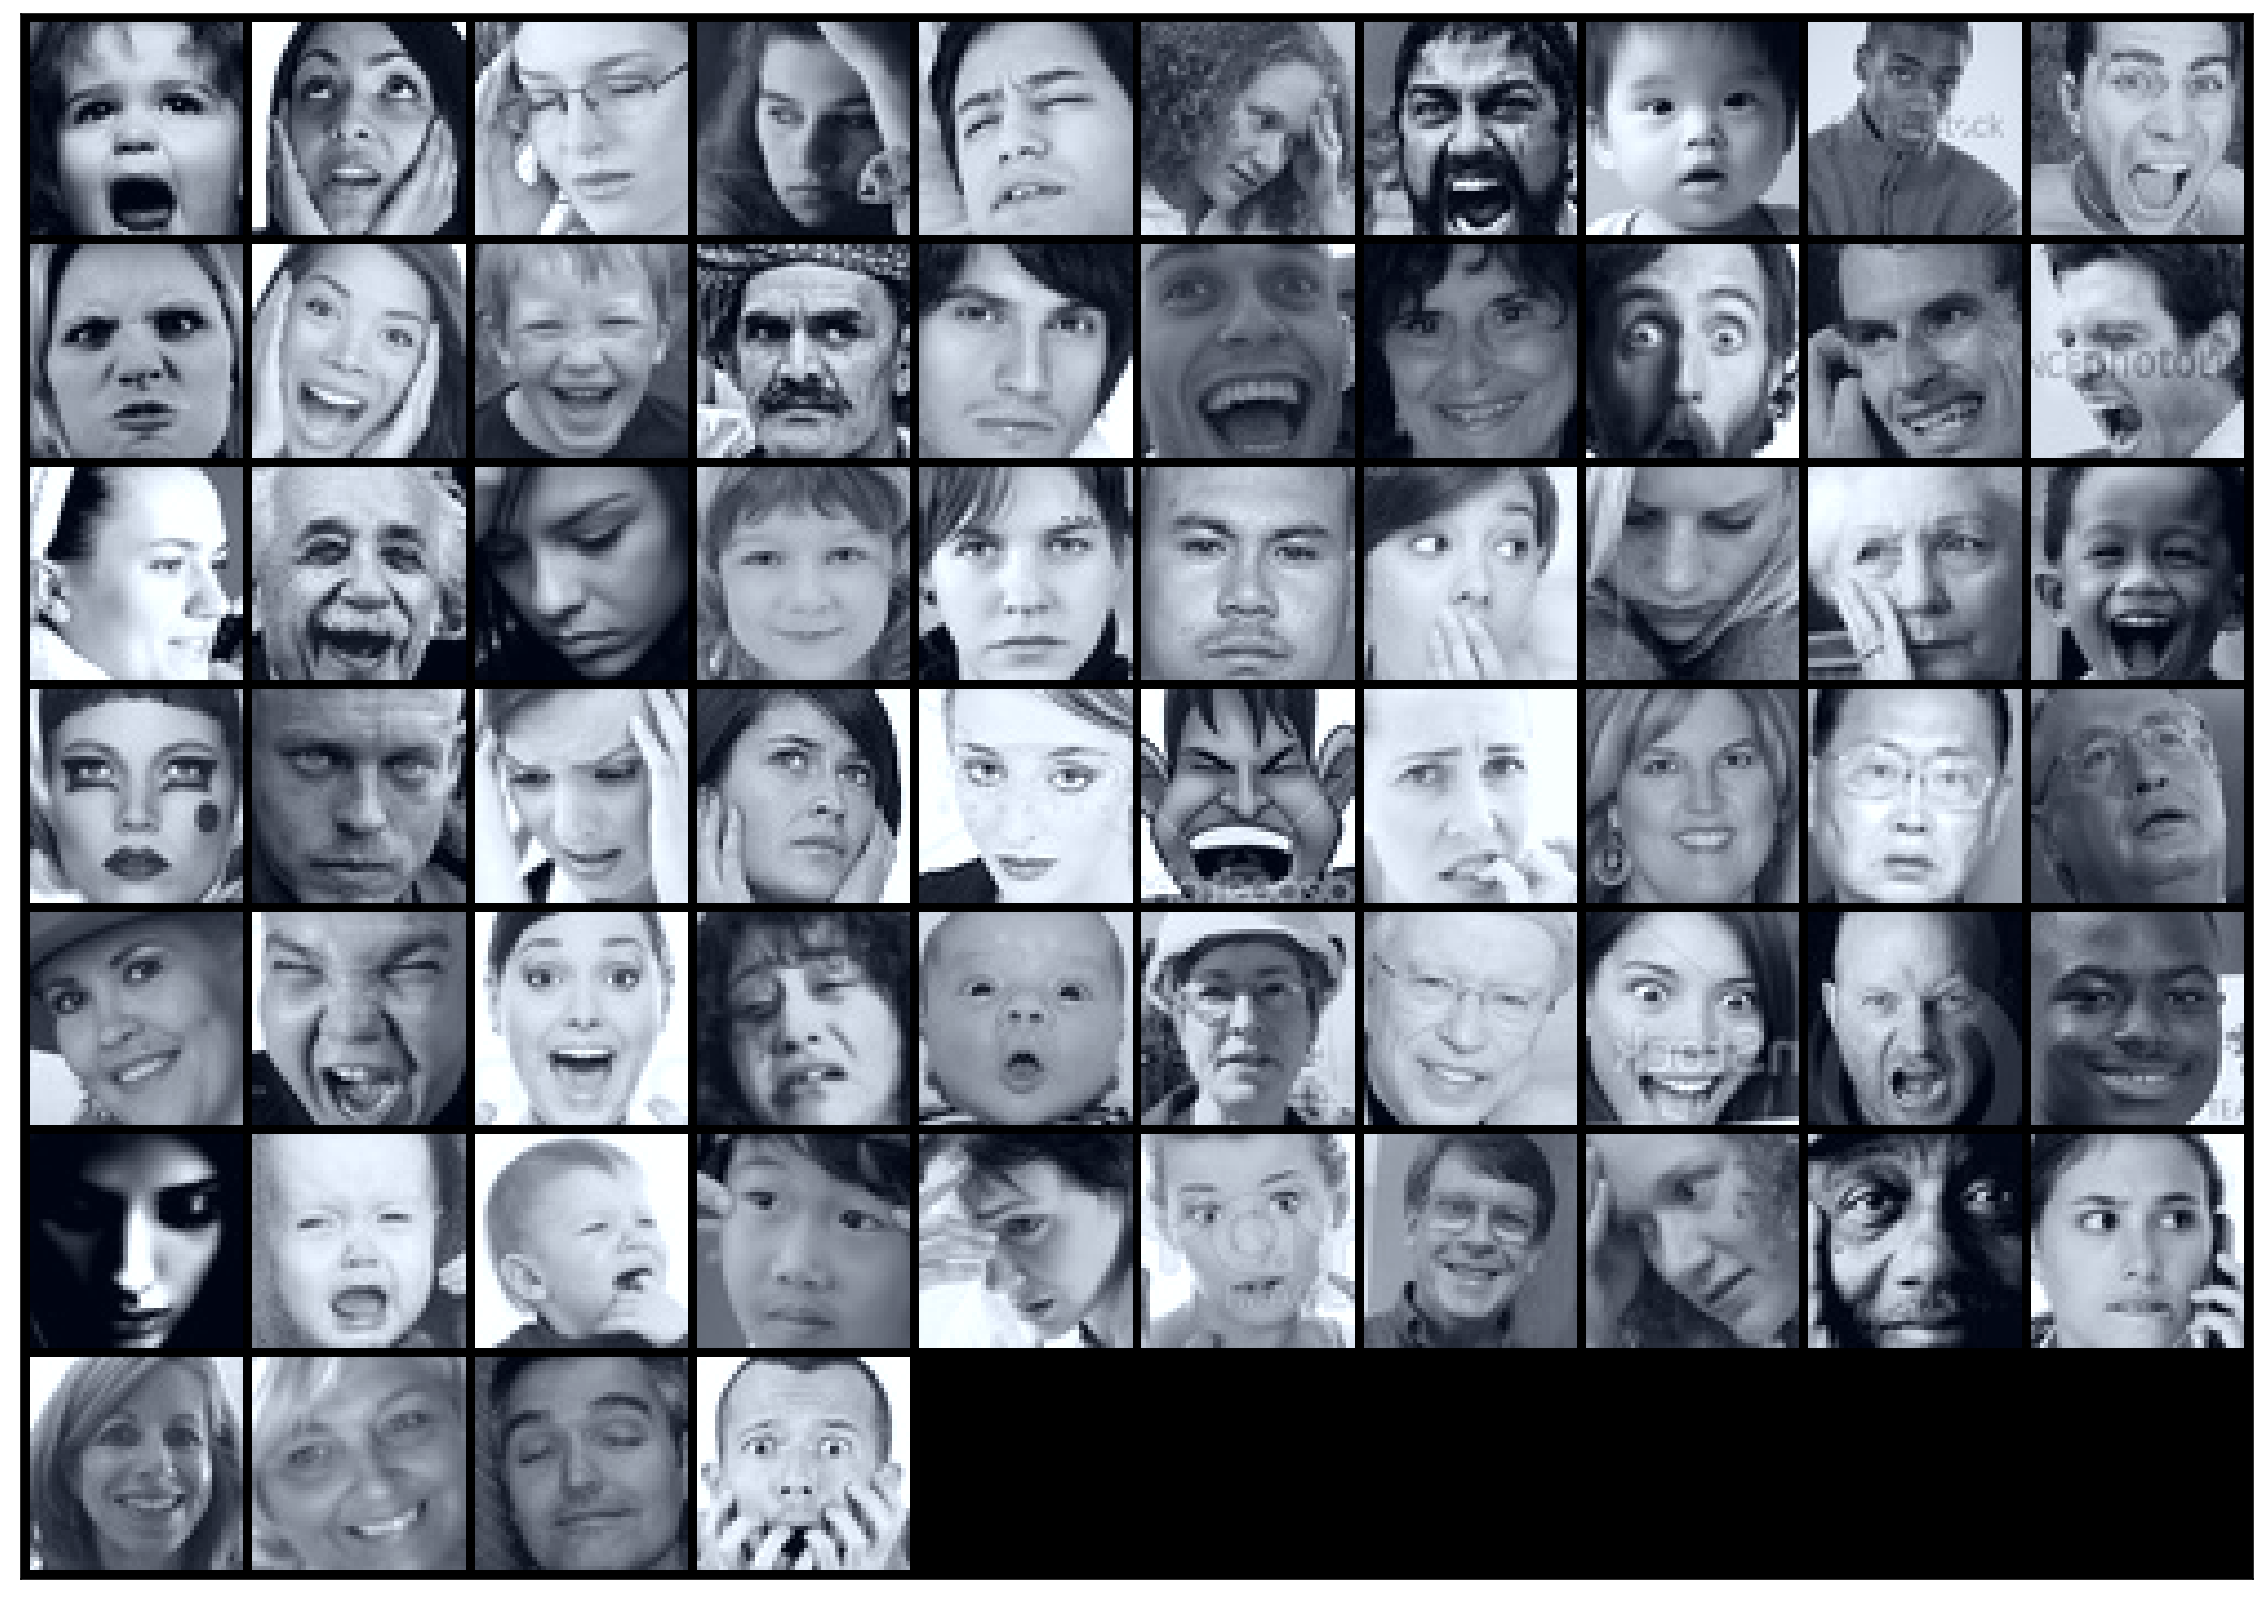

In [24]:
show_batch(dataloaders['trainloader'])

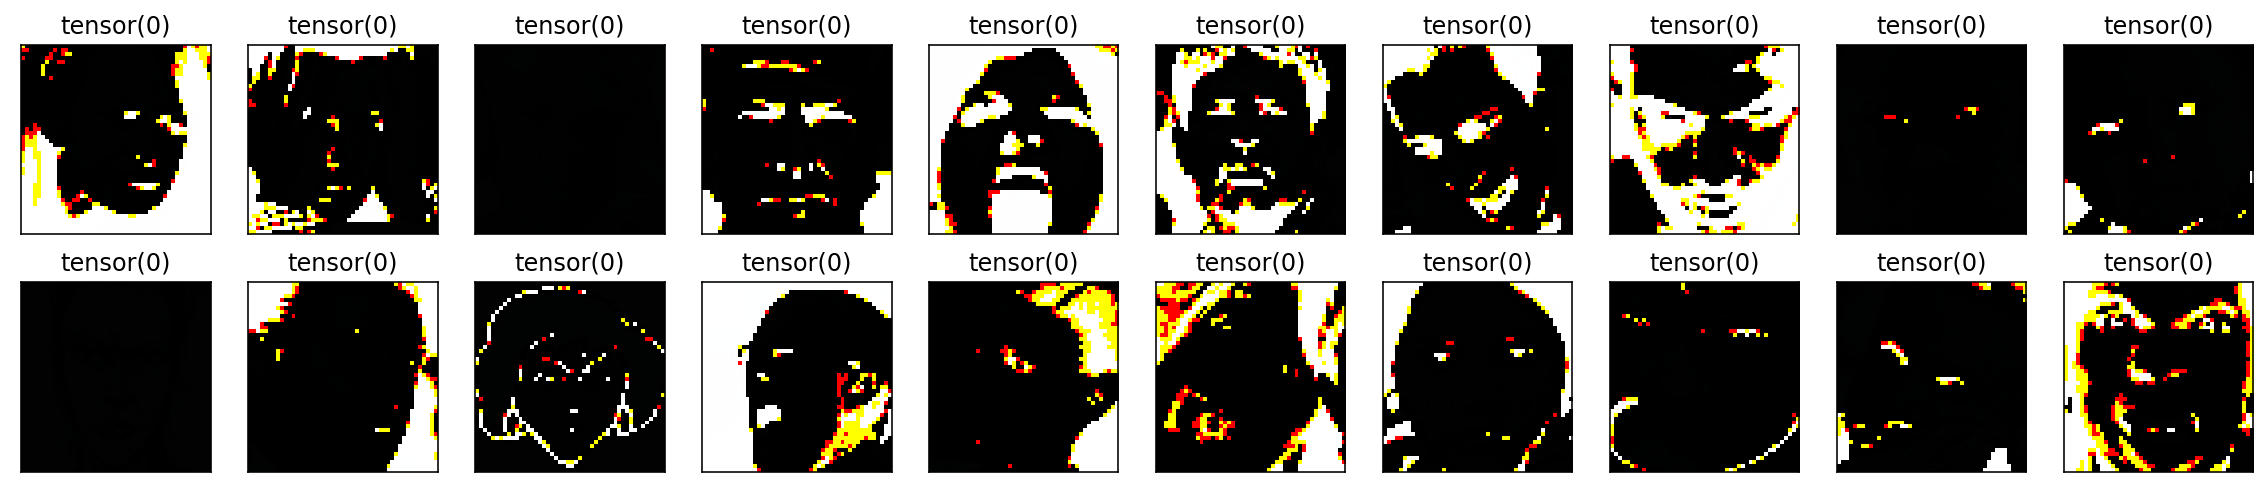

In [26]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).astype(np.uint8))

image,label=iter(dataloaders['validloader']).next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(image[idx])
    ax.set_title(label[idx])

## Neural Network Architecture

In [27]:
# Defining a class for the feedforward network.
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer.
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers.
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output log softmax.
            Arguments
            ---------
            self: all layers
            x: tensor vector
        '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout.        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)

        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [28]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab

Using TensorFlow backend.


## Validation Function

In [29]:
# Definig a function for the validation pass.

def validation(model, validloader, criterion, device):
    ''' Builds a feedforward network with arbitrary hidden layers, 
        returns the validation loss and  validation accuracy.
        
        Arguments
        ---------
        model: the pre-trained model.
        validloader: generator, the validation dataset.
        criterion: loss function.
        device: the used device for the training [GPU or CPU].
    '''
    # Initiate the validation accuracy & validation loss with 0.
    valid_accuracy = 0
    valid_loss = 0
    # Move model to the device
    model.to(device)
    
    # Looping through the data batches.
    for inputs, labels in validloader:
        # Move input and label tensors to the device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        #inputs.resize_(inputs.shape[0], 48*48)

        # Forward pass through the network.
        output = model.forward(inputs)
        # Increase the validation loss by the loss of the predicted output with the labels.
        valid_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, so take exponential to get the probabilities.
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label.
        equality = (labels.data == ps.max(dim=1)[1])
        # Accuracy is number of correct predictions divided by all predictions, so we just take the mean.
        valid_accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, valid_accuracy

##Training Function

In [43]:
# Definig a function for the training process

def training(model, criterion, optimizer, device, trainloader, validloader, epochs=5, print_every=40*6):
    ''' Builds a feedforward network with arbitrary hidden layers.
        
        Arguments
        ---------
        model: the pre-trained model.
        optimizer: which we will take a step with it to update the weights.
        criterion: loss function.
        device: the used device for the training [GPU or CPU].
        trainloader: generator, the training dataset.
        validloader: generator, the validation dataset.
        epochs: integer, number of trainings.
        print_every: integer, printing the updates on loss & accuracy every print_every value.
    '''
    
    steps = 0
    running_loss = 0
  
    train_l=[]
    valid_l=[]
    #b = TensorBoardColab()
  
    # Move model to the device
    model.to(device)
    
    for e in range(epochs):
        # Model in training mode, dropout is on.
        model.train()
        for inputs, labels in trainloader:
            # Move input and label tensors to the device.
            inputs, labels = inputs.to(device), labels.to(device)
            
            steps += 1
            
            # zero-ing the accumalated gradients.
            optimizer.zero_grad()

            # Forward pass through the network
            output = model.forward(inputs)
            # Calculate the loss
            loss = criterion(output, labels)
            # Backward pass through the network 
            loss.backward()
            # Take a step with the optimizer to update the weights
            optimizer.step()
            running_loss += loss.item()
            train_l.append(running_loss)

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation saves memory and computations, so will speed up inference
                with torch.no_grad():
                    valid_loss, valid_accuracy = validation(model, validloader, criterion, device)
                valid_l.append(valid_loss)
                
                
                # Displaying the validation loss and accuracy during the training. 
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(valid_accuracy/len(validloader)))
            
                running_loss = 0
                
                # Make sure dropout and grads are back on for training
                model.train()
            
   
                # Recording to Tensorboard -------------------------------------------------
 
               # tb.save_value('Valid_Loss', 'valid_loss', steps, loss.item())
                #tb.save_value('Training_Loss', 'running_loss', steps, loss.item())
                #tb.save_value('Valid_Accuracy', 'valid_accuracy', steps, loss.item())
    
                
                
    return valid_l,train_l

## VGG19
* Reference: Very Deep Convolutional Networks for Large-Scale Image Recognition



### Model Architecture
- A fixed size of (224 * 224) RGB image was given as input to this network which means that the matrix was of shape (224,224,3).
- The only preprocessing that was done is that they subtracted the mean RGB value from each pixel, computed over the whole training set.
- Used kernels of (3 * 3) size with a stride size of 1 pixel, this enabled them to cover the whole notion of the image.
- spatial padding was used to preserve the spatial resolution of the image.
- max pooling was performed over a 2 * 2 pixel windows with sride 2.
- this was followed by Rectified linear unit(ReLu) to introduce non-linearity to make the model classify better and to improve computational time as the previous models used tanh or sigmoid functions this proved much better than those.
- implemented three fully connected layers from which first two were of size 4096 and after that a layer with 1000 channels for 1000-way ILSVRC classification and the final layer is a softmax function.

The column E in the following table is for VGG19 (other columns are for other variants of VGG models):

In [44]:
# Using a Pretrained Network
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Hyperparameters Tunings

In [45]:
# Setting all hyper parameters in a dictionary to ease the dealing.
hyper_parameters = {'input_size': 25088,
                    'output_size': 7,
                    'hidden_layers': [1024],
                    'drop_p': 0.2,
                    'learn_rate': 0.0001,
                    'epochs': 50,
                    'model': 'vgg19'
}

### Configure Classifier

In [46]:
# Freezing the parameters so we don't backprop through them, 
# we will backprop through the classifier parameters only later
for param in model.parameters():
    param.requires_grad = False

# Creating Feedforward Classifier
classifier = Network(input_size = hyper_parameters['input_size'], 
                     output_size = hyper_parameters['output_size'], 
                     hidden_layers = hyper_parameters['hidden_layers'], 
                     drop_p = hyper_parameters['drop_p'])

model.classifier = classifier

### Setup Loss Function & Classifier

In [47]:
# Define the criterion (Loss function). 
criterion = nn.NLLLoss()
# Define the optimizer. Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=hyper_parameters['learn_rate'])

### Device Check - GPU/CPU

In [48]:
# Checking if the 'GPU' is available to pass it for the device variable, and if it's not, pass the 'CPU'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using Device:', device)
print()

#additional CUDA info - when using
if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))
  print('Memory Usage:')
  print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using Device: cuda:0

Tesla K80
Memory Usage:
Allocated: 0.9 GB
Cached:    1.7 GB


In [49]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  2 08:39:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   2125MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training the model

In [50]:
# Train the model with a pre-trained network.

valid, train = training(model, criterion, optimizer, device,
                        trainloader = dataloaders['trainloader'],
                        validloader = dataloaders['validloader'],
                        epochs = hyper_parameters['epochs'])

Epoch: 1/50..  Training Loss: 1.666..  Validation Loss: 1.568..  Validation Accuracy: 0.394
Epoch: 2/50..  Training Loss: 1.567..  Validation Loss: 1.533..  Validation Accuracy: 0.399
Epoch: 2/50..  Training Loss: 1.537..  Validation Loss: 1.533..  Validation Accuracy: 0.405
Epoch: 3/50..  Training Loss: 1.525..  Validation Loss: 1.514..  Validation Accuracy: 0.420
Epoch: 3/50..  Training Loss: 1.498..  Validation Loss: 1.508..  Validation Accuracy: 0.419
Epoch: 4/50..  Training Loss: 1.478..  Validation Loss: 1.508..  Validation Accuracy: 0.424
Epoch: 4/50..  Training Loss: 1.460..  Validation Loss: 1.512..  Validation Accuracy: 0.420
Epoch: 5/50..  Training Loss: 1.460..  Validation Loss: 1.496..  Validation Accuracy: 0.425
Epoch: 5/50..  Training Loss: 1.446..  Validation Loss: 1.498..  Validation Accuracy: 0.434
Epoch: 6/50..  Training Loss: 1.424..  Validation Loss: 1.484..  Validation Accuracy: 0.437
Epoch: 6/50..  Training Loss: 1.418..  Validation Loss: 1.492..  Validation Accu

## Plotting the Training Loss & Validation Loss over Training

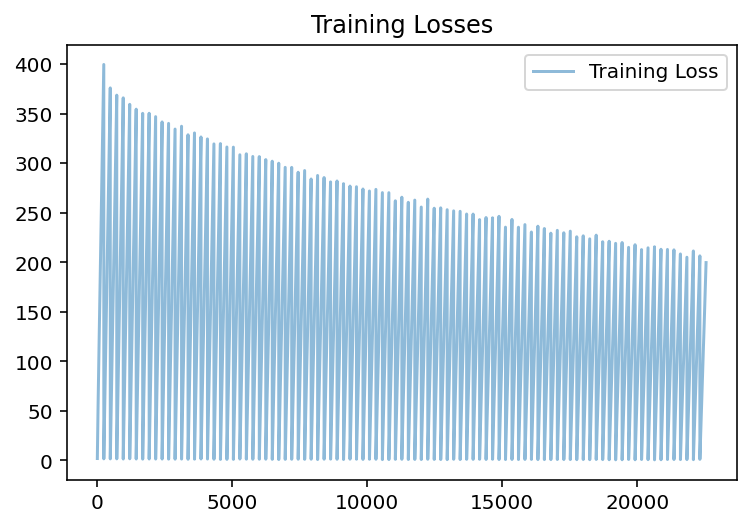

In [51]:
plt.plot(np.array(train),label='Training Loss', alpha=0.5)
plt.title("Training Losses")
plt.legend()

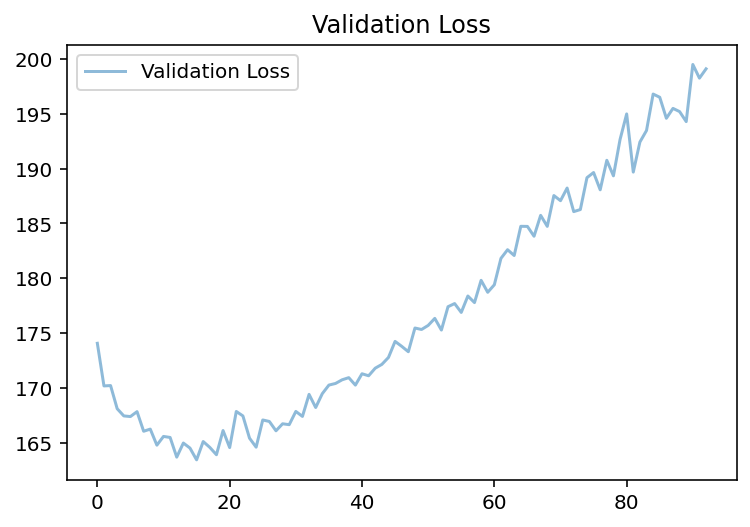

In [52]:
plt.plot(np.array(valid), label='Validation Loss', alpha=0.5)
plt.title("Validation Loss")
plt.legend()

### Saving the trained model

In [56]:
# Saving the model, weights, biases, mapping of classes to indices, and hyper parameters to rebuild the model.

model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'input_size': hyper_parameters['input_size'],
              'output_size': hyper_parameters['output_size'],
              'hidden_layers': hyper_parameters['hidden_layers'],
              'drop_p': hyper_parameters['drop_p'],
              'model': hyper_parameters['model'],
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict()}

filepath = '/content/gdrive/My Drive/Colab Notebooks/vgg19.pth'

torch.save(checkpoint, filepath)

## Loading a trained model

In [57]:
# Defining a function that loads a checkpoint and rebuilds the model.

def load_checkpoint(filepath):
    ''' Builds a function to load the model, returns the model.
        
        Arguments
        ---------
        filepath: string, the path of the model checkpoint.
    '''
    # Loading the checkpoint
    checkpoint = torch.load(filepath)
    # using the pre-trained Network
    if checkpoint['model'] == 'vgg19':
        model = models.vgg19(pretrained=True)
    
    # Freezing the parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
       
    # Creating the Feedforward Classifier
    classifier = Network(input_size = checkpoint['input_size'],
                         output_size = checkpoint['output_size'],
                         hidden_layers = checkpoint['hidden_layers'], 
                         drop_p = checkpoint['drop_p'])
    
    # Replacing pre-trained calssifier by ours.
    model.classifier = classifier
    # Loading the weights and biases.
    model.load_state_dict(checkpoint['state_dict'])
    # Loading the classes to indices of our saved model.
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [58]:
# Loading the model & Calculating the spent time.
start = time()
filepath = '/content/gdrive/My Drive/Colab Notebooks/vgg19.pth'
model = load_checkpoint(filepath)
print("Loading vgg19.pth time = ", time() - start)

Loading vgg19.pth time =  2.359355926513672


##Testing Fucntion

In [61]:
# Dfefining a function for testing

def testing(model, testloader):
    ''' Builds a function to test the model, returns the testing accuracy.
        
        Arguments
        ---------
        model: the pre-trained model.
        testloader: generator, the testing dataset.
    '''
    
    # Checking if the 'GPU' is available to pass it for the device variable, and if it's not, pass the 'CPU'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Model in inference mode, dropout is off
    model.eval()
    # Move model to the device
    model.to(device)
    accuracy = 0
    steps=0
    #tb = TensorBoardColab()
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Turn off gradients for testing saves memory and computations, so will speed up inference
        with torch.no_grad():
            # Forward pass through the network to get the outputs
            output = model.forward(inputs)
        
        # take exponential to get the probabilities from log softmax output.
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
        #tb.save_value('Test_Accuracy', 'accuracy', steps,accuracy)
        steps+=1
    
        
    test_accuracy = accuracy / len(testloader)

    
    return test_accuracy

In [62]:
test_accuracy = testing(model, dataloaders['testloader'])
print("Test Accuracy: {:.3f}".format(test_accuracy))

Test Accuracy: 0.460


In [63]:
# Avergae testing

test_sum = 0
for i in range(5):
    start = time()
    test_accuracy = testing(model, dataloaders['testloader'])
    test_sum += test_accuracy
    print("Test Accuracy{}: {:.3f}".format(i, test_accuracy))
    print("testing vgg19_2.pth time = ", time() - start)
    print()

print("Average Test Accuracy: {:.3f}".format(test_sum/5))

Test Accuracy0: 0.460
testing vgg19_2.pth time =  1.9868192672729492

Test Accuracy1: 0.460
testing vgg19_2.pth time =  1.7881593704223633

Test Accuracy2: 0.460
testing vgg19_2.pth time =  1.7928612232208252

Test Accuracy3: 0.460
testing vgg19_2.pth time =  1.8006095886230469

Test Accuracy4: 0.460
testing vgg19_2.pth time =  1.7671177387237549

Average Test Accuracy: 0.460


## Using the trained model for Inference
* Method 1: Displaying top (k) most likely predicted classes

In [64]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image and converts  into an object 
        that can be used as input to a trained model, returns an Numpy array.

        Arguments
        ---------
        image_path: string, path of the image.
    '''
    
    im = Image.open(image_path).convert("RGB")
    # Process a PIL image for use in a PyTorch model
    preprocess = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))
                                     ])
    preprocessed_im = preprocess(im)
    
    return preprocessed_im

* Method 2: Displaying the image along with the probability of each class

In [65]:
def predict(image_path, model, device, topk):
    ''' Predict the class (or classes) of an image using a trained deep learning model,
        returns the probabilities and classes of most likely (k) predicted classes.
        
        Arguments
        ---------
        image_path: string, path of the image.
        model: the pre-trained model.
        device: string, the used device for inference which the user passed.
        topk: integer, number of most likely (k) classes.
    '''
    
    # Move model to the device
    model.to(device)
    # Model in inference mode, dropout is off
    model.eval()
    
    image = process_image(image_path)
    #print(image.size()) >>> torch.Size([3, 244, 244])
    image.unsqueeze_(0) 
    #print(image.size()) >>> torch.Size([1, 3, 244, 244])
    
    # Move image tensors to the device.
    image = image.to(device)
    
    # Turn off gradients for testing saves memory and computations, so will speed up inference.
    with torch.no_grad():
        # Forward pass through the network to get the outputs.
        prediction = model.forward(image)
    # Take exponential to get the probabilities from log softmax output.
    ps = torch.exp(prediction)
    # The most likely (topk) predicted prbabilities with their indices.
    probs, top_k_indices = ps.topk(topk)
    
    # Extracting the classes from the indices.
    classes = []
    for indice in top_k_indices.cpu()[0]:
        classes.append(list(model.class_to_idx)[indice.numpy()]) # Take the class from the index
    
    return probs.cpu()[0].numpy(), classes

In [66]:

def predict_classes_names(cat_to_name, classes_output):
    ''' Mapping the category labels to category names, returns the category names.
        
        Arguments
        ---------
        cat_to_name: dict, label mapping from category label to category name. 
        classes_output: list, The most likely (k) predicted classes labels.
    '''

    # Creating the a list contains the category names from the classes labels.
    classes_names = []
    for i in classes_output:
        classes_names.append(cat_to_name[i])
    
    return classes_names

Top 3 most likely Classes
Predicted Emotion (1):                angry	 ... 	Predicted Class Probability: 0.416
Predicted Emotion (2):                  sad	 ... 	Predicted Class Probability: 0.254
Predicted Emotion (3):              neutral	 ... 	Predicted Class Probability: 0.097



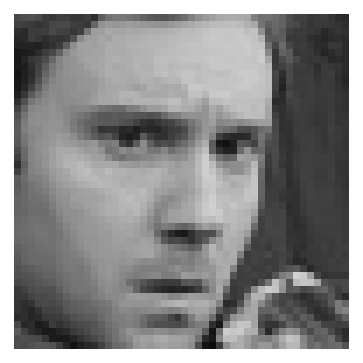

In [75]:
image_path = "/content/images/train/0/0.jpg"
# Most likely top k predicted classes
topk = 3

probs, classes = predict(image_path, model, device, topk)

classes = predict_classes_names(cat_to_name, classes_output= classes)

print("Top {} most likely Classes".format(topk))
for i in range(len(probs)):
    print("Predicted Emotion ({}): {:>20}\t ... \tPredicted Class Probability: {:.3f}".format(i+1, classes[i], probs[i]))
print()

# load color (BGR) image
img = cv2.imread(image_path)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the image, along with bounding box
plt.figure(figsize=(3,6))
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

In [76]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 48, 48).cpu().numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(7), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(7))
    
    ax2.set_yticklabels(cat_to_name.values(), size='medium');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

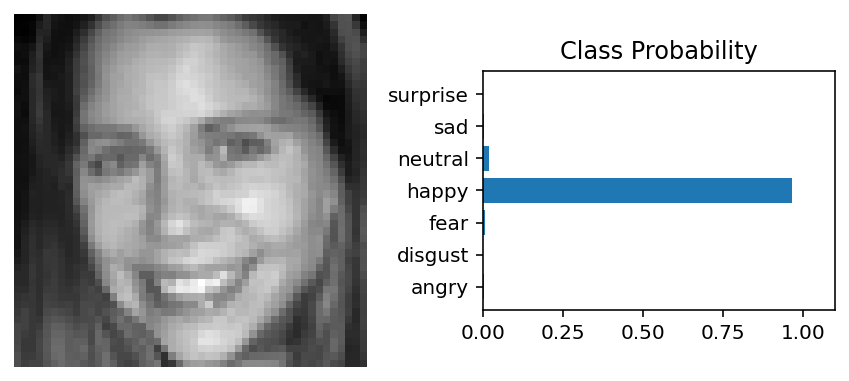

In [77]:
# Test out our network!

model.eval()

dataiter = iter(dataloaders['testloader'])
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

img = images[0].unsqueeze_(0)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
img = img[:,0,:,:]
img = img.view(1, 48, 48)

# Plot the image and probabilities
view_classify(img.view(1, 48, 48), ps)